In [1]:
#ignoring warnings
import warnings
warnings.simplefilter('ignore')

#importing neccesary modules
import sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns

import sklearn
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
from sklearn.model_selection import GridSearchCV, train_test_split

import xgboost
from xgboost import XGBRegressor, DMatrix

In [2]:
#python package version information
print('Python version:{}'.format(sys.version))
print('Numpy version:{}'.format(np.__version__))
print('Pandas version:{}'.format(pd.__version__))
print('MatlpotLib version:{}'.format(matplotlib.__version__))
print('Seaborn version:{}'.format(sns.__version__))
print('Sci-Kit Learn version:{}'.format(sklearn.__version__))
print('XGBoost version:{}'.format(xgboost.__version__))

Python version:3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
Numpy version:1.23.3
Pandas version:1.4.4
MatlpotLib version:3.5.2
Seaborn version:0.12.1
Sci-Kit Learn version:1.1.3
XGBoost version:1.7.1


In [8]:
gbp = pd.read_csv('gbpusd_new.csv', index_col=0, parse_dates=True, skipinitialspace=True)
gbp = gbp.drop('volume', axis=1)
gbp.describe()

,open,high,low,close
count,4951.000000,4951.000000,4951.000000,4951.000000
mean,1.556106,1.561995,1.549812,1.556147
std,0.234722,0.235358,0.234580,0.234754
min,1.072846,1.083541,0.637389,1.072754
25%,1.336720,1.341742,1.330725,1.336675
50%,1.554219,1.559819,1.548707,1.553905
75%,1.730493,1.737393,1.722076,1.730463
max,2.108415,2.115820,2.098812,2.108192


In [9]:
gbp.isna().sum()

open     0
high     0
low      0
close    0
dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


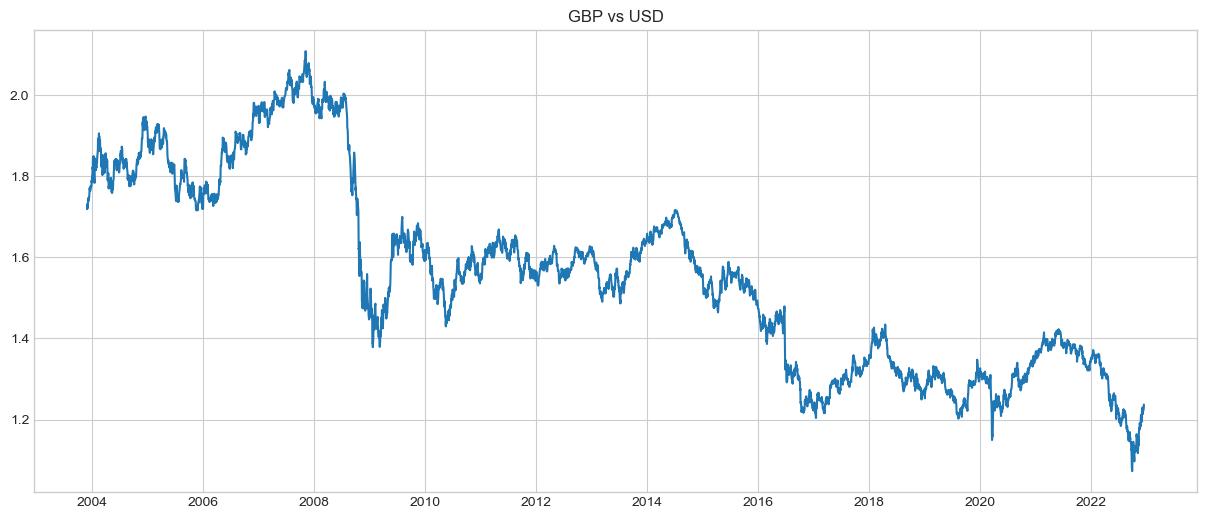

In [11]:
plt.figure(figsize=(15,6))
plt.plot(gbp.close)
plt.title('GBP vs USD')
plt.legend()
plt.show()

In [12]:
def generate_features(df):
    """ Generate features for a stock/index/currency/commodity based on historical price and performance
    Args:
        df (dataframe with columns "open", "close", "high", "low", "volume")
    Returns:
        dataframe, data set with new features
    """
    df_new = pd.DataFrame()
    
    # 6 original features
    df_new['open'] = df['open']
    df_new['open_1'] = df['open'].shift(1)
    df_new['close_1'] = df['close'].shift(1)
    df_new['high_1'] = df['high'].shift(1)
    df_new['low_1'] = df['low'].shift(1)
    
    # 50 original features
    # average price
    df_new['avg_price_5'] = df['close'].rolling(window=5).mean().shift(1)
    df_new['avg_price_30'] = df['close'].rolling(window=21).mean().shift(1)
    df_new['avg_price_90'] = df['close'].rolling(window=63).mean().shift(1)
    df_new['avg_price_365'] = df['close'].rolling(window=252).mean().shift(1)
    
    # average price ratio
    df_new['ratio_avg_price_5_30'] = df_new['avg_price_5'] / df_new['avg_price_30']
    df_new['ratio_avg_price_905_'] = df_new['avg_price_5'] / df_new['avg_price_90']
    df_new['ratio_avg_price_5_365'] = df_new['avg_price_5'] / df_new['avg_price_365']
    df_new['ratio_avg_price_30_90'] = df_new['avg_price_30'] / df_new['avg_price_90']
    df_new['ratio_avg_price_30_365'] = df_new['avg_price_30'] / df_new['avg_price_365']
    df_new['ratio_avg_price_90_365'] = df_new['avg_price_90'] / df_new['avg_price_365']                                            
    
    
    # standard deviation of prices
    df_new['std_price_5'] = df['close'].rolling(window=5).std().shift(1)
    df_new['std_price_30'] = df['close'].rolling(window=21).std().shift(1)
    df_new['std_price_90'] = df['close'].rolling(window=63).std().shift(1)                                               
    df_new['std_price_365'] = df['close'].rolling(window=252).std().shift(1)
    
    # standard deviation ratio of prices 
    df_new['ratio_std_price_5_30'] = df_new['std_price_5'] / df_new['std_price_30']
    df_new['ratio_std_price_5_90'] = df_new['std_price_5'] / df_new['std_price_90']
    df_new['ratio_std_price_5_365'] = df_new['std_price_5'] / df_new['std_price_365']
    df_new['ratio_std_price_30_90'] = df_new['std_price_30'] / df_new['std_price_90'] 
    df_new['ratio_std_price_30_365'] = df_new['std_price_30'] / df_new['std_price_365']                                               
    df_new['ratio_std_price_90_365'] = df_new['std_price_90'] / df_new['std_price_365']                                                
    
                                       
    # return
    df_new['return_1'] = ((df['close'] - df['close'].shift(1)) / df['close'].shift(1)).shift(1)
    df_new['return_5'] = ((df['close'] - df['close'].shift(5)) / df['close'].shift(5)).shift(1)
    df_new['return_30'] = ((df['close'] - df['close'].shift(21)) / df['close'].shift(21)).shift(1)
    df_new['return_90'] = ((df['close'] - df['close'].shift(63)) / df['close'].shift(63)).shift(1)                                                
    df_new['return_365'] = ((df['close'] - df['close'].shift(252)) / df['close'].shift(252)).shift(1)
    
    #average of return
    df_new['moving_avg_5'] = df_new['return_1'].rolling(window=5).mean()
    df_new['moving_avg_30'] = df_new['return_1'].rolling(window=21).mean()
    df_new['moving_avg_30'] = df_new['return_1'].rolling(window=63).mean()
    df_new['moving_avg_365'] = df_new['return_1'].rolling(window=252).mean()
    
    # the target
    df_new['close'] = df['close']
    df_new = df_new.dropna(axis=0)
    return df_new

data = generate_features(gbp)

In [13]:
data.head()

,open,open_1,close_1,high_1,low_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,ratio_avg_price_5_30,...,ratio_std_price_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
Date,,,,,,,,,,,,,,,,,,,,,
2004-11-19,1.848190,1.859600,1.848292,1.863794,1.847917,1.852915,1.843006,1.810547,1.816310,1.005376,...,0.739046,-0.005970,0.002809,0.024601,0.015988,0.075466,0.000576,0.000264,0.000308,1.860084
2004-11-22,1.857597,1.848190,1.860084,1.860984,1.847507,1.853475,1.845091,1.811351,1.816825,1.004544,...,0.768460,0.006380,0.001507,0.024107,0.028013,0.074999,0.000315,0.000451,0.000306,1.859808
2004-11-23,1.859808,1.857597,1.859808,1.860915,1.852916,1.856153,1.846631,1.812423,1.817348,1.005157,...,0.794162,-0.000149,0.007253,0.017687,0.037661,0.076215,0.001456,0.000598,0.000311,1.868984
2004-11-24,1.868600,1.859808,1.868984,1.872905,1.852916,1.859312,1.848521,1.813575,1.817937,1.005838,...,0.829547,0.004934,0.008523,0.021699,0.040408,0.086179,0.001708,0.000640,0.000348,1.881114
2004-11-25,1.881503,1.868600,1.881114,1.882707,1.867797,1.863656,1.850393,1.814931,1.818524,1.007168,...,0.870511,0.006490,0.011682,0.021351,0.047573,0.085403,0.002337,0.000749,0.000345,1.891790


In [14]:
data.describe()

,open,open_1,close_1,high_1,low_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,ratio_avg_price_5_30,...,ratio_std_price_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
count,4698.000000,4698.000000,4698.000000,4698.000000,4698.000000,4698.000000,4698.000000,4698.000000,4698.000000,4698.000000,...,4698.000000,4698.000000,4698.000000,4698.000000,4698.000000,4698.000000,4698.000000,4698.000000,4698.000000,4698.000000
mean,1.542138,1.542271,1.542288,1.548047,1.536085,1.542556,1.543637,1.546544,1.558837,0.999306,...,0.540690,-0.000070,-0.000348,-0.001532,-0.004947,-0.016209,-0.000070,-0.000078,-0.000064,1.542157
std,0.232758,0.232761,0.232772,0.233303,0.232750,0.232622,0.232078,0.230062,0.220861,0.011851,...,0.253892,0.006017,0.013682,0.026650,0.045603,0.087882,0.002743,0.000733,0.000363,0.232772
min,1.072846,1.072846,1.072754,1.083541,0.637389,1.086064,1.113868,1.141930,1.240515,0.930400,...,0.126217,-0.076038,-0.098125,-0.155624,-0.215635,-0.313657,-0.019989,-0.003800,-0.001441,1.072754
25%,1.327536,1.327717,1.327832,1.333049,1.322358,1.326649,1.328985,1.335111,1.344619,0.992786,...,0.353475,-0.003257,-0.007958,-0.016438,-0.030939,-0.061950,-0.001582,-0.000483,-0.000239,1.327629
50%,1.543448,1.543508,1.543519,1.548863,1.536948,1.543223,1.545641,1.546898,1.566739,0.999900,...,0.488436,-0.000072,-0.000087,-0.000007,-0.000125,-0.012982,-0.000007,0.000012,-0.000038,1.543424
75%,1.658519,1.658739,1.658636,1.663624,1.654985,1.657673,1.658097,1.657255,1.658613,1.006878,...,0.664312,0.003161,0.007873,0.015374,0.022411,0.048046,0.001585,0.000364,0.000201,1.658423
max,2.108415,2.108415,2.108192,2.115820,2.098812,2.094231,2.071908,2.049206,2.008467,1.039915,...,1.413592,0.035463,0.071423,0.103025,0.178179,0.202640,0.013957,0.002646,0.000750,2.108192


<AxesSubplot:>

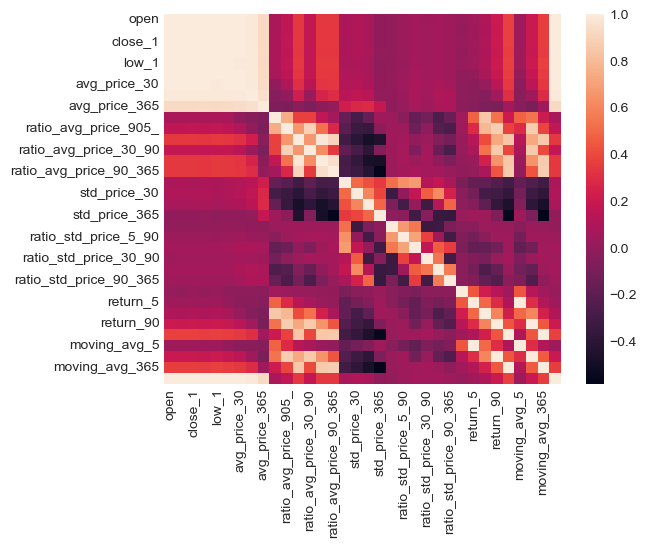

In [15]:
sns.heatmap(data.corr())

### SEGREGATING TRAIN AND TEST DATA

In [36]:
#import datetime module
import datetime

#segregate data for training
end_train = datetime.datetime(2020, 1, 1, 0, 0)
data_train = data.loc[:end_train]
data_test = data.loc[end_train:]
data_train.describe()

,open,open_1,close_1,high_1,low_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,ratio_avg_price_5_30,...,ratio_std_price_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
count,3928.000000,3928.000000,3928.000000,3928.000000,3928.000000,3928.000000,3928.000000,3928.000000,3928.000000,3928.000000,...,3928.000000,3928.000000,3928.000000,3928.000000,3928.000000,3928.000000,3928.000000,3928.000000,3928.000000,3928.000000
mean,1.589524,1.589660,1.589676,1.595587,1.583325,1.589955,1.591049,1.593790,1.607190,0.999323,...,0.540038,-0.000071,-0.000359,-0.001459,-0.004328,-0.018161,-0.000072,-0.000069,-0.000072,1.589543
std,0.223451,0.223453,0.223468,0.224023,0.223543,0.223298,0.222713,0.220822,0.209058,0.011747,...,0.257642,0.005934,0.013336,0.026499,0.046252,0.088241,0.002672,0.000744,0.000365,0.223469
min,1.202198,1.202198,1.202198,1.208751,0.637389,1.206338,1.214593,1.228475,1.263604,0.939163,...,0.126217,-0.076038,-0.098125,-0.155624,-0.215635,-0.313657,-0.019989,-0.003800,-0.001441,1.202198
25%,1.426854,1.426976,1.427358,1.435508,1.418883,1.429075,1.432141,1.437611,1.510835,0.992937,...,0.350858,-0.003253,-0.008026,-0.016149,-0.029789,-0.062408,-0.001600,-0.000463,-0.000240,1.427129
50%,1.574803,1.574890,1.574865,1.581415,1.569403,1.575695,1.576035,1.577701,1.584027,0.999900,...,0.490063,-0.000078,-0.000123,0.000327,0.000440,-0.015414,-0.000013,0.000021,-0.000048,1.574791
75%,1.734982,1.735328,1.735117,1.740924,1.727093,1.736368,1.744864,1.751486,1.790047,1.006877,...,0.653836,0.003153,0.007925,0.015399,0.022867,0.045563,0.001590,0.000371,0.000191,1.734500
max,2.108415,2.108415,2.108192,2.115820,2.098812,2.094231,2.071908,2.049206,2.008467,1.039915,...,1.413592,0.035463,0.056592,0.103025,0.178179,0.171854,0.011093,0.002646,0.000664,2.108192


In [38]:
X_train = data_train.drop('close', axis='columns')
y_train = data_train.close

X_test = data_test.drop('close', axis='columns')
y_test = data_test.close

#checking the shape of the train and test data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3928, 33), (771, 33), (3928,), (771,))

### SCALING THE PREDICTOR DATA

In [39]:
#initiating standard scaler
scaler = StandardScaler()

#fit the scaler in training features
scaler.fit(X_train)

#Rescale both sets using the trained scaler
X_scaled_train = scaler.transform(X_train)
X_scaled_test = scaler.transform(X_test)

In [40]:
def show_evolution(prediction, model_name):
    evolution_df = pd.DataFrame();
    evolution_df["evolution_test_y"] = (y_test - X_test["close_1"].shift()).values
    evolution_df["evolution_prediction"] = (prediction - X_test["close_1"].shift()).values

    evolution_df = evolution_df.dropna().sort_values('evolution_test_y', ascending=False)

    plt.figure(figsize = (18,9))
    plt.style.use('seaborn-whitegrid')
    plot_truth, = plt.plot(evolution_df["evolution_test_y"].values)
    plot_lin, = plt.plot(evolution_df["evolution_prediction"].values)
    plt.legend([plot_truth, plot_lin], ['Truth', 'Linear Regression'])
    plt.title('Price evolution : Prediction vs Truth - '+model_name)
    plt.show()

### LINEAR REGRESSION (LIN)

In [41]:
from sklearn.linear_model import LinearRegression
lin = LinearRegression()

lin.fit(X_scaled_train, y_train)
predictions_lin = lin.predict(X_scaled_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_lin)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_lin)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_lin)))

RMSE: 0.001
MAE: 0.001
R^2: 1.000


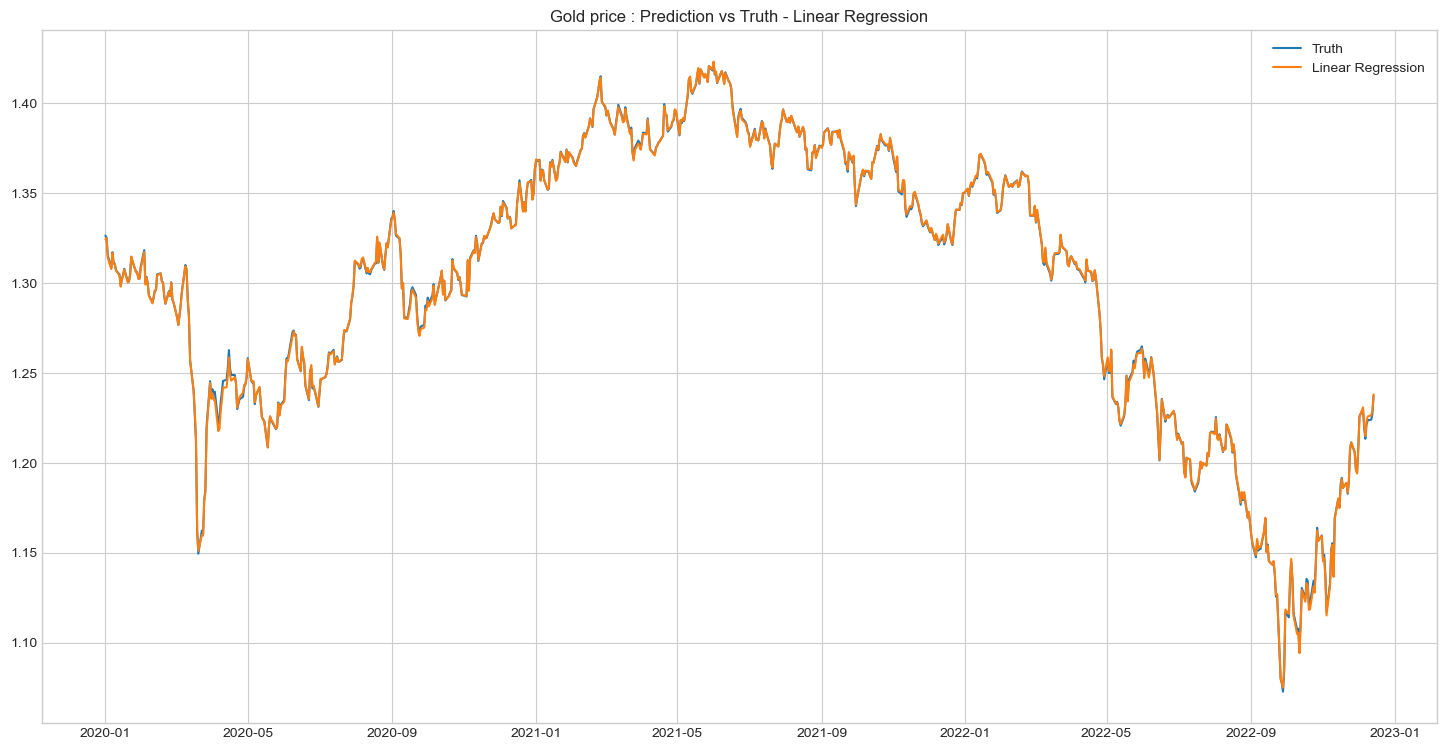

In [42]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plt.style.use('seaborn-whitegrid')
plot_truth, = plt.plot(dates, y_test)
plot_lin, = plt.plot(dates, predictions_lin)
plt.legend([plot_truth, plot_lin], ['Truth', 'Linear Regression'])
plt.title('Gold price : Prediction vs Truth - Linear Regression')
plt.show()

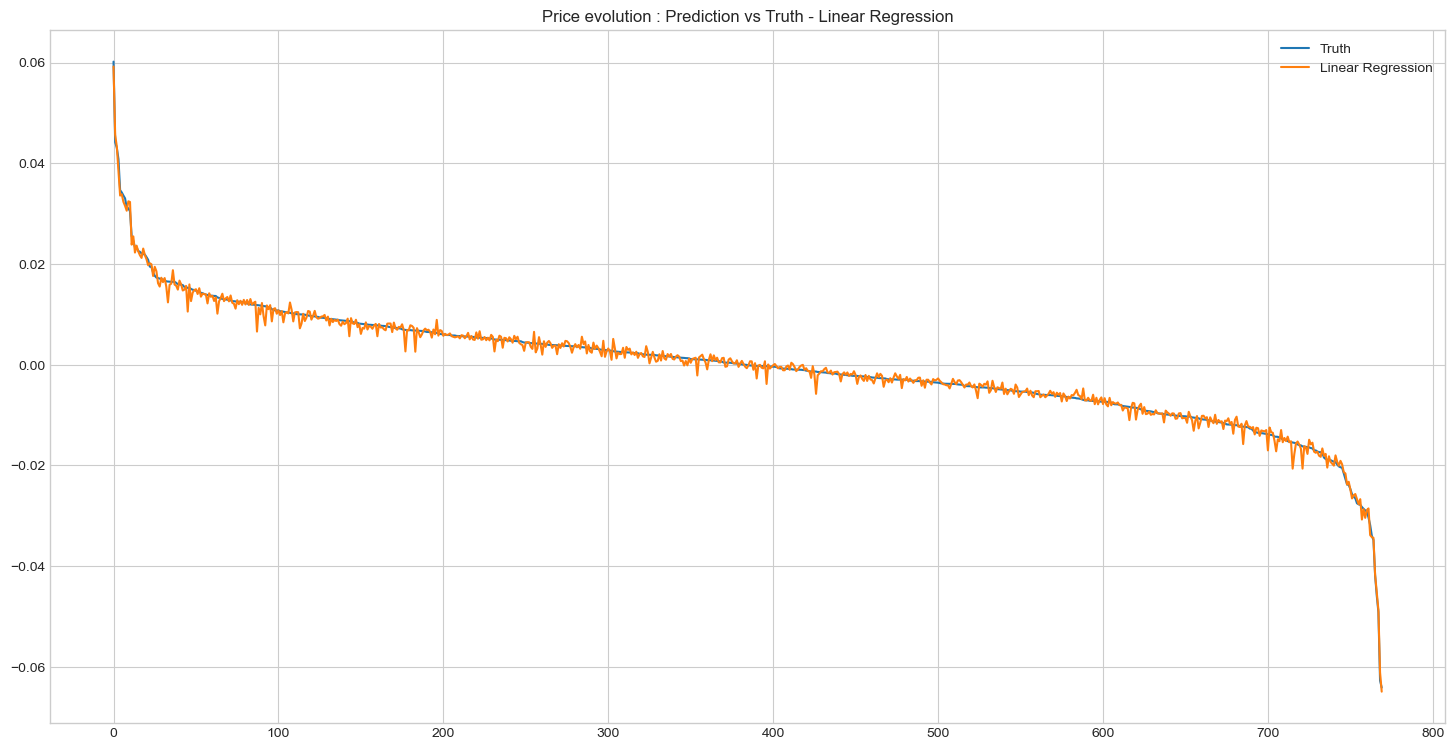

In [43]:
show_evolution(predictions_lin, 'Linear Regression')

### SGD REGRESSOR (SGD)

In [44]:
# First experiment with linear regression

# SGD is very sensitive to data with features at different scales. Hence we need to do feature scaling before training.
#search for the SGD-based linear regression with the optimal set of parameters. 
from sklearn.linear_model import SGDRegressor

param_grid = {
    'penalty':['l1', 'l2', 'elasticnet'],
    "alpha": [1e-5, 3e-5, 1e-4],
    "eta0": [0.01, 0.03, 0.1],
}

sgd = SGDRegressor()
grid_search = GridSearchCV(sgd, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_scaled_train, y_train)

print(grid_search.best_params_)

sgd_best = grid_search.best_estimator_
#print(grid_search.best_score_)

predictions_sgd = sgd_best.predict(X_scaled_test)

#evaluating the predictions
print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_sgd)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_sgd)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_sgd)))

{'alpha': 0.0001, 'eta0': 0.03, 'penalty': 'l2'}
RMSE: 0.006
MAE: 0.005
R^2: 0.993


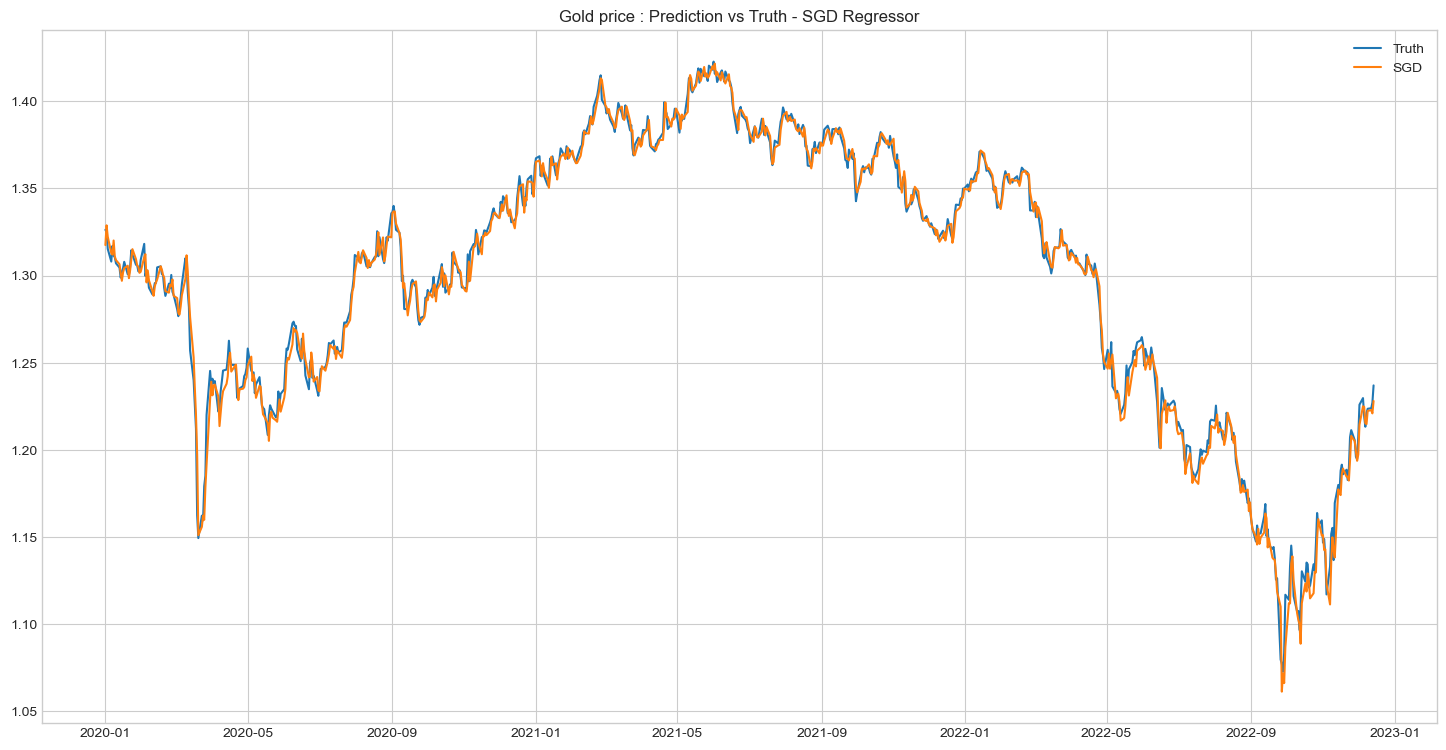

In [45]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_sgd, = plt.plot(dates, predictions_sgd)
plt.legend([plot_truth, plot_sgd], ['Truth', 'SGD'])
plt.title('Gold price : Prediction vs Truth - SGD Regressor')
plt.style.use('seaborn-whitegrid')
plt.show()

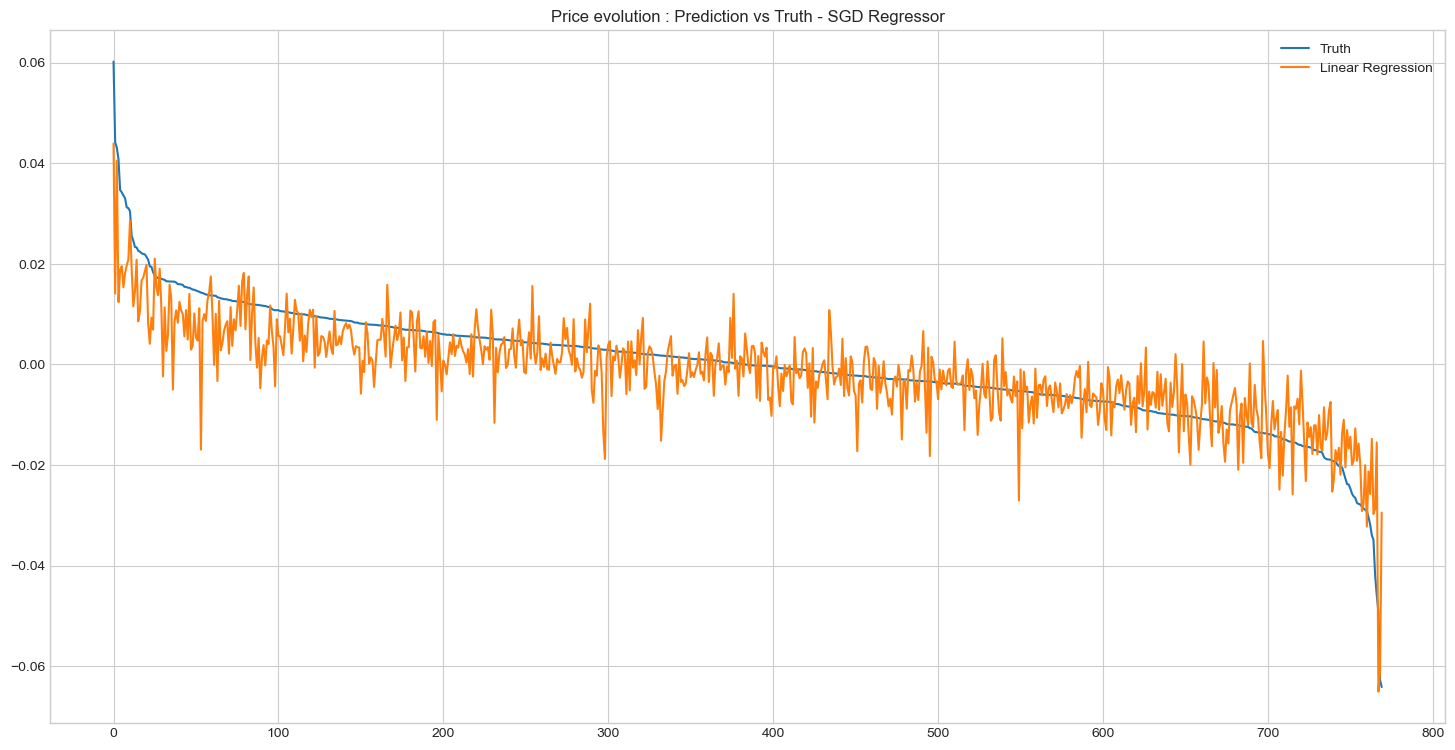

In [46]:
show_evolution(predictions_sgd, 'SGD Regressor')

### Extreme Gradient Boosting Regressor (XGB)

In [49]:
xgb = XGBRegressor()

data_dmatrix = DMatrix(data=X_train,
                           label=y_train)

xgb_param_grid = {'learning_rate': [0.001, 0.01, 0.1, 1],
                  'n_estimators': [50, 100, 200, 300],
                  'subsample': [0.3, 0.5, 0.7, 1]}

grid_search = GridSearchCV(estimator=xgb,    
                        param_grid=xgb_param_grid,
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                       n_jobs=-1)

grid_search.fit(X_train, y_train) 

print("Best parameters found: ",grid_search.best_params_)

xgb_best = grid_search.best_estimator_

xgb_best.fit(X_train,y_train)
predictions_xgb = xgb_best.predict(X_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_xgb)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_xgb)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_xgb)))

Fitting 4 folds for each of 64 candidates, totalling 256 fits
Best parameters found:  {'learning_rate': 1, 'n_estimators': 50, 'subsample': 0.7}
RMSE: 0.024
MAE: 0.012
R^2: 0.906


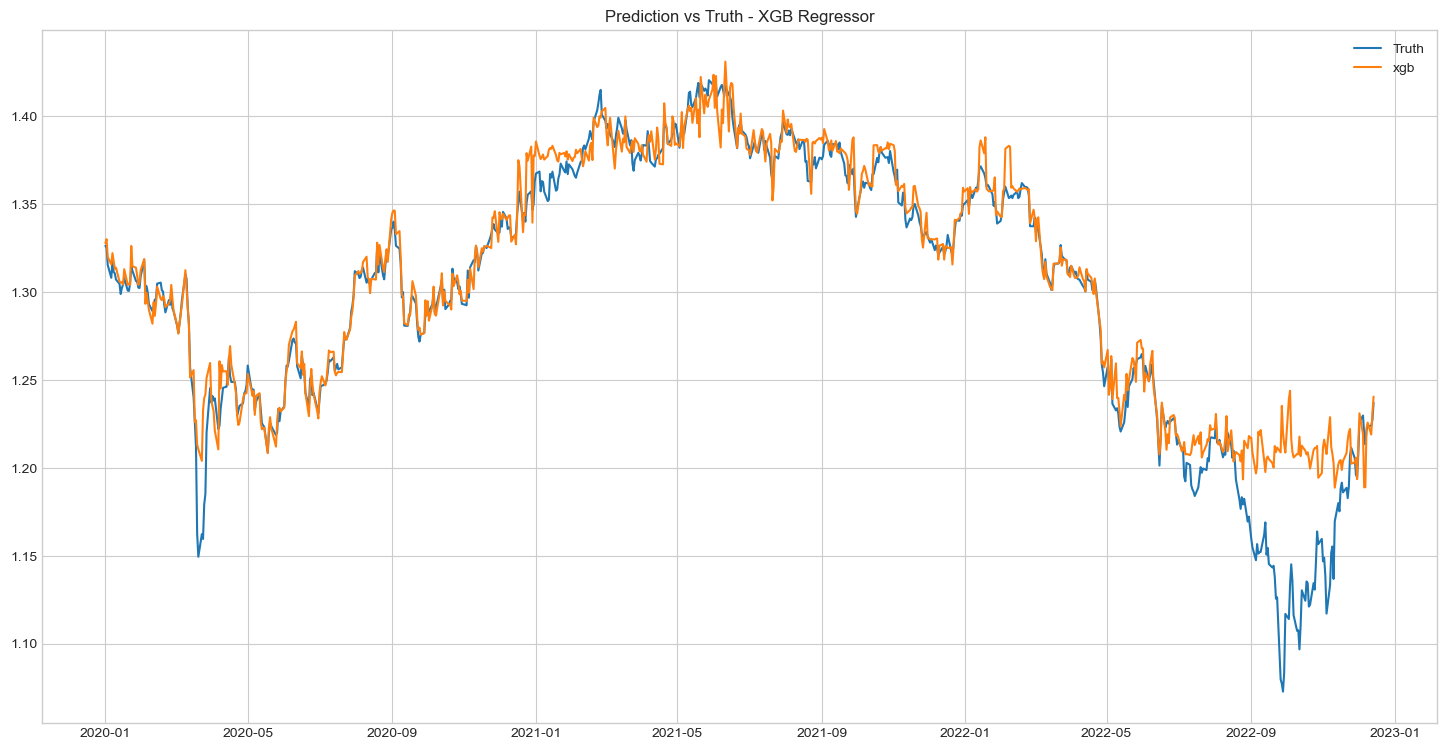

In [68]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_xgb, = plt.plot(dates, predictions_xgb)
plt.legend([plot_truth, plot_xgb], ['Truth', 'xgb'])
plt.title('Prediction vs Truth - XGB Regressor')
plt.show()

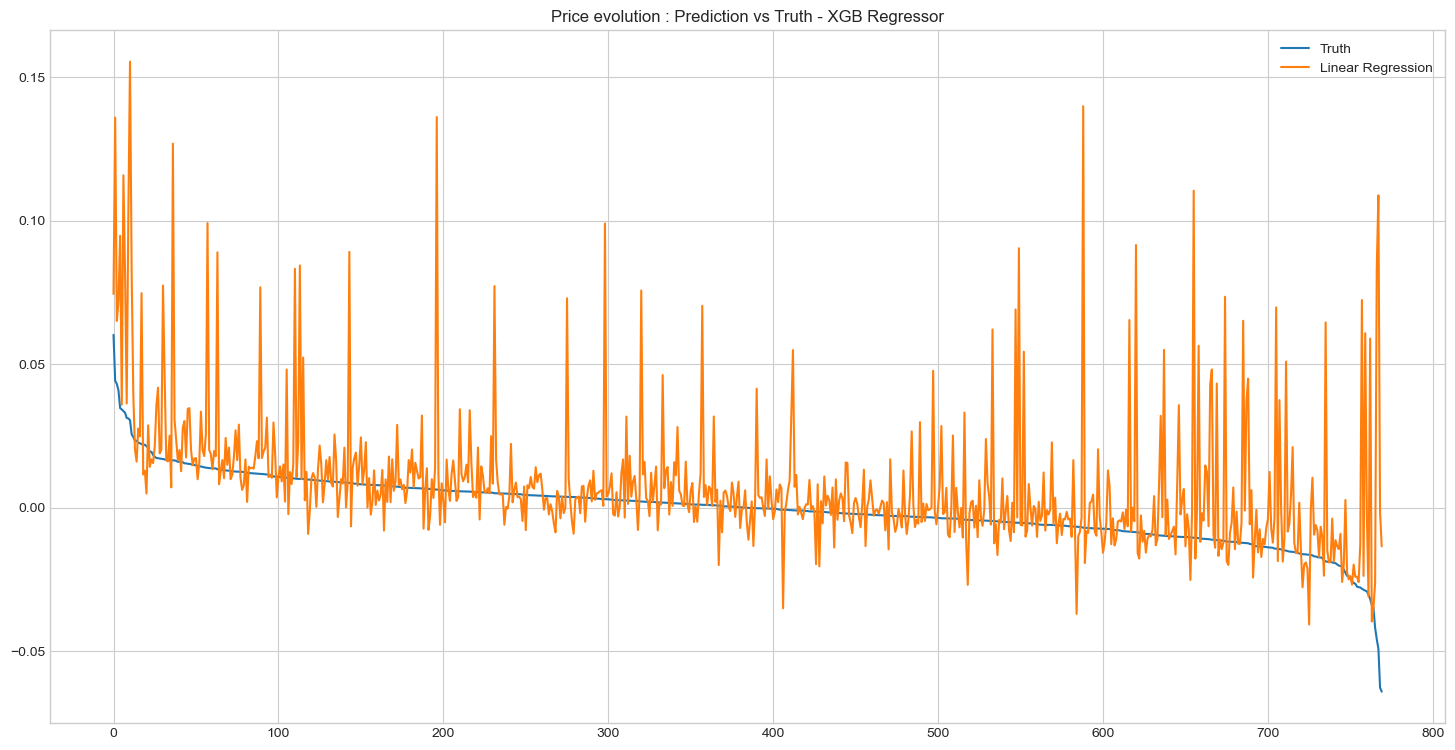

In [52]:
show_evolution(predictions_xgb, 'XGB Regressor')

### Bagging Regressor (BGR)

In [53]:
BaggingRegressor?

In [54]:
bgr = BaggingRegressor(base_estimator=lin, n_estimators=100, oob_score=True, n_jobs=-1)

bgr.fit(X_scaled_train, y_train)
predictions_bgr = bgr.predict(X_scaled_test)

print('OOB: {0:.3f}'.format(bgr.oob_score))
print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_bgr)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_bgr)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_bgr)))

OOB: 1.000
RMSE: 0.001
MAE: 0.001
R^2: 1.000


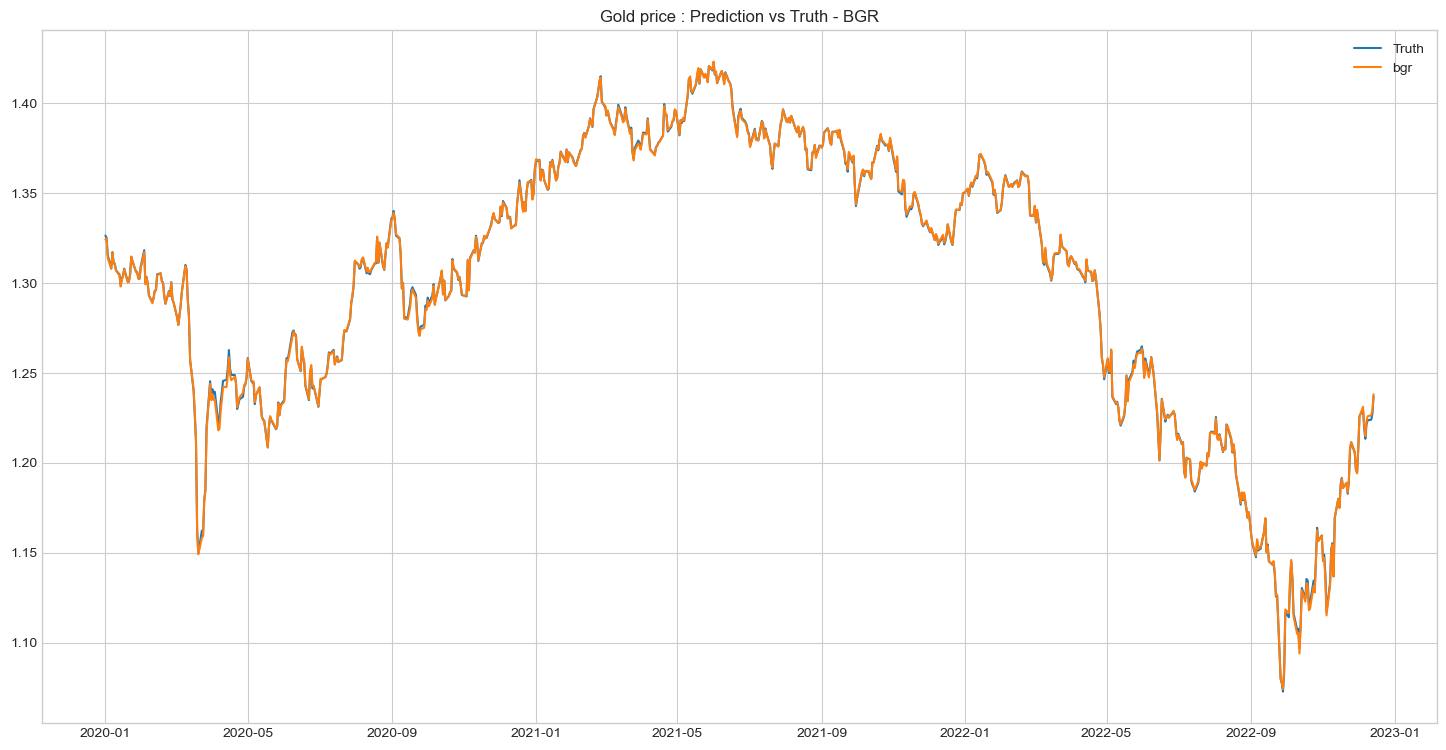

In [55]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_bgr, = plt.plot(dates, predictions_bgr)
plt.legend([plot_truth, plot_bgr], ['Truth', 'bgr'])
plt.title('Gold price : Prediction vs Truth - BGR')
plt.show()

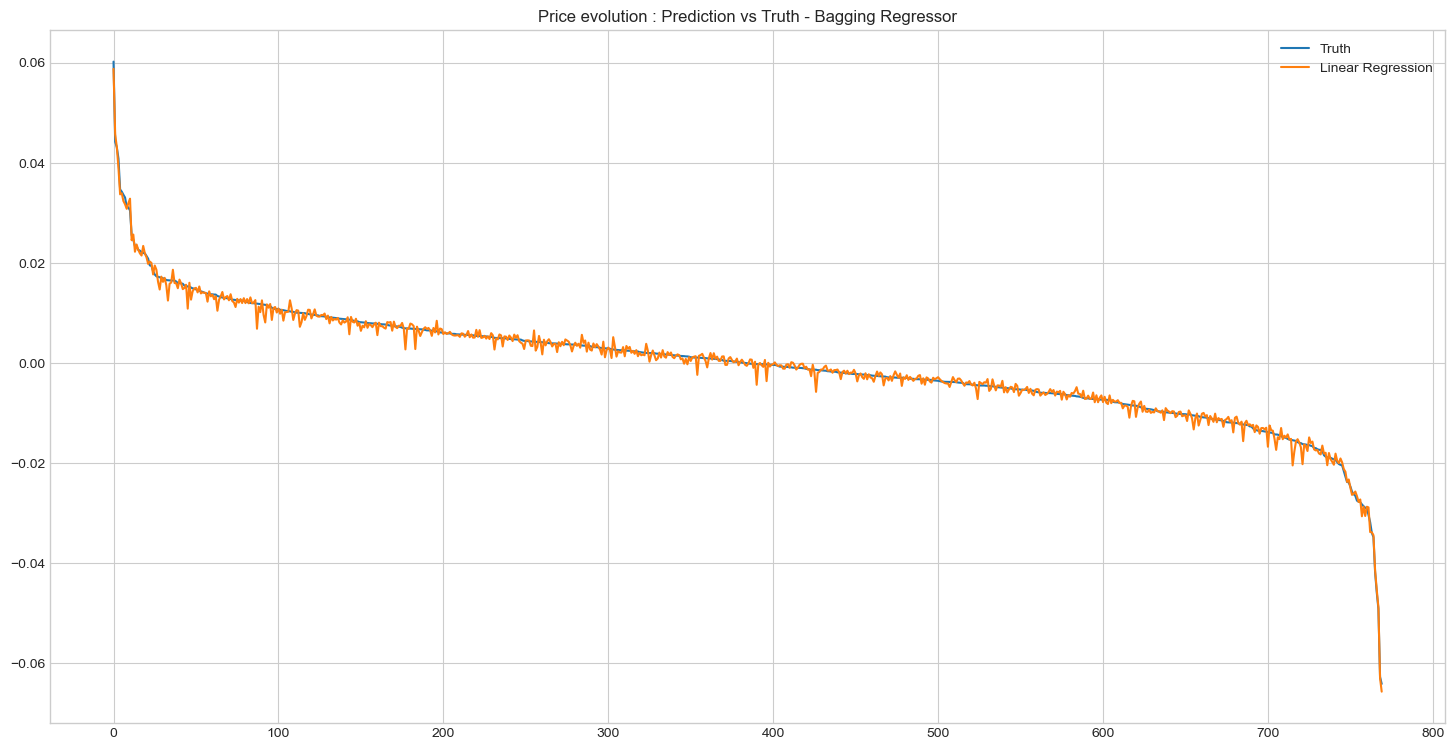

In [56]:
show_evolution(predictions_bgr, 'Bagging Regressor')

### Random Forest Regressor (RF)

In [59]:
param_grid = {
    "max_depth": [30, 50],
    "min_samples_split": [5, 10, 20],

}

rf = RandomForestRegressor(n_estimators=100)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
# print(grid_search.best_score_)

rf_best = grid_search.best_estimator_
predictions_rf = rf_best.predict(X_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_rf)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_rf)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_rf)))


{'max_depth': 50, 'min_samples_split': 5}
RMSE: 0.020
MAE: 0.007
R^2: 0.930


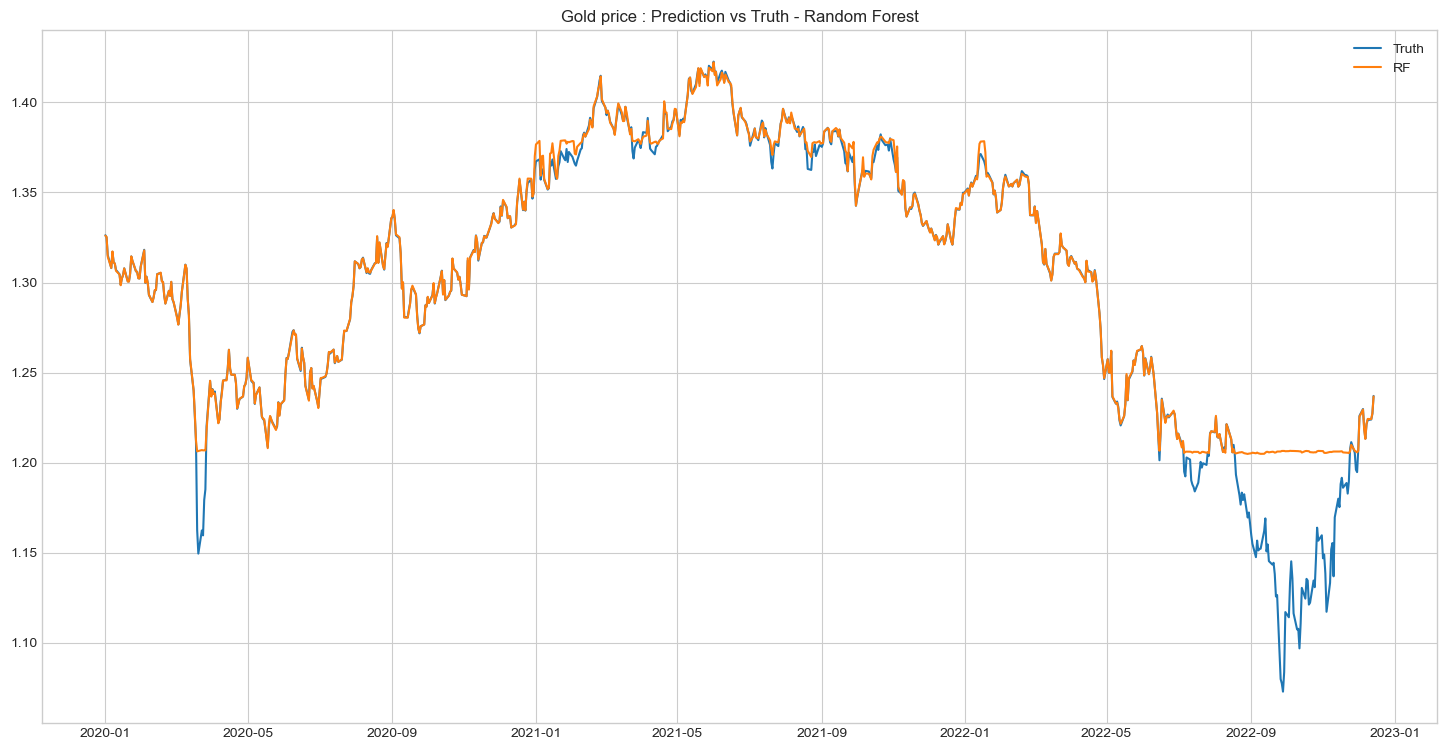

In [60]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_rf, = plt.plot(dates, predictions_rf)
plt.legend([plot_truth, plot_rf], ['Truth', 'RF'])
plt.title('Gold price : Prediction vs Truth - Random Forest')
plt.show()

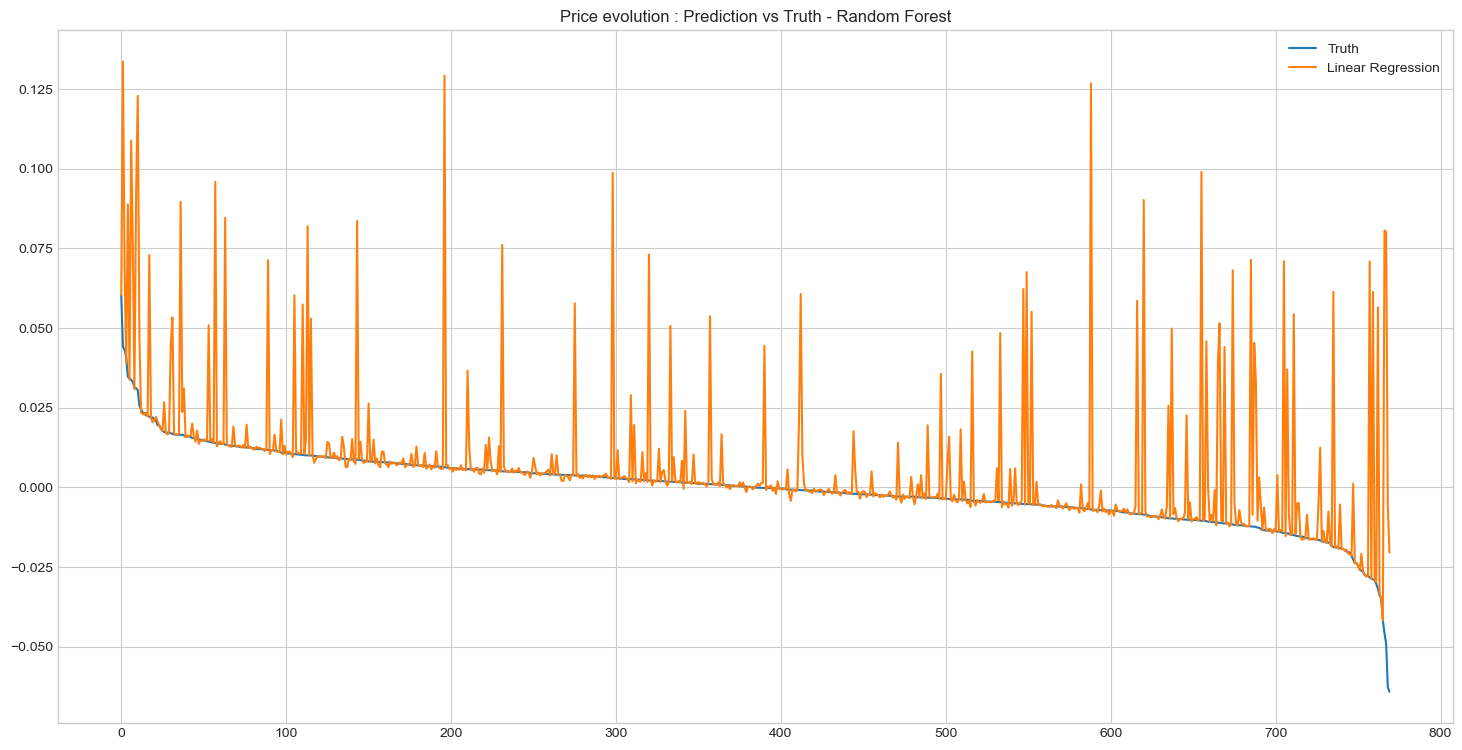

In [61]:
show_evolution(predictions_rf, 'Random Forest')

The model with the least mean_absolute_error:
 BGR    0.000673
dtype: float64


LIN    0.000688
SGD    0.004705
XGB    0.011762
BGR    0.000673
RFR    0.006808
dtype: float64

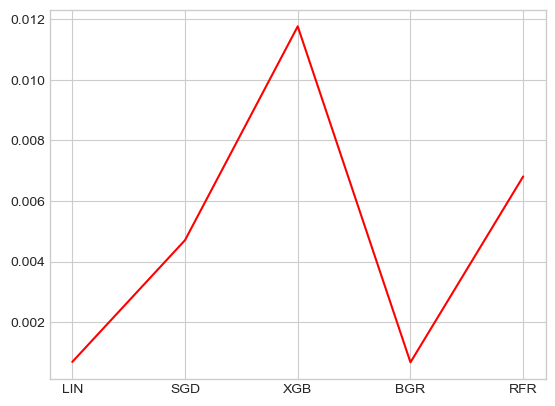

In [62]:
mae_scoring = pd.Series({'LIN':mean_absolute_error(y_test, predictions_lin),
                'SGD':mean_absolute_error(y_test, predictions_sgd),
                'XGB':mean_absolute_error(y_test, predictions_xgb),
                #'VTR':mean_absolute_error(y_test, predictions_vtr),
                'BGR':mean_absolute_error(y_test, predictions_bgr),
                'RFR':mean_absolute_error(y_test, predictions_rf)})

#filtering the regressor with the least mean_absolute_error value
filter = mae_scoring.min()
mae_min = mae_scoring[mae_scoring == mae_scoring.min()]
print('The model with the least mean_absolute_error:\n',mae_min)

plt.plot(mae_scoring, 'r')
mae_scoring

### Saving, Loading and Predicting with the BGR Model

In [63]:
#saving the BGR model with sklearn:joblib
joblib.dump(bgr, 'bgr_eurusd_10062019.pkl')

['bgr_eurusd_10062019.pkl']

In [64]:
#loading the saved model
model = joblib.load('bgr_eurusd_10062019.pkl')

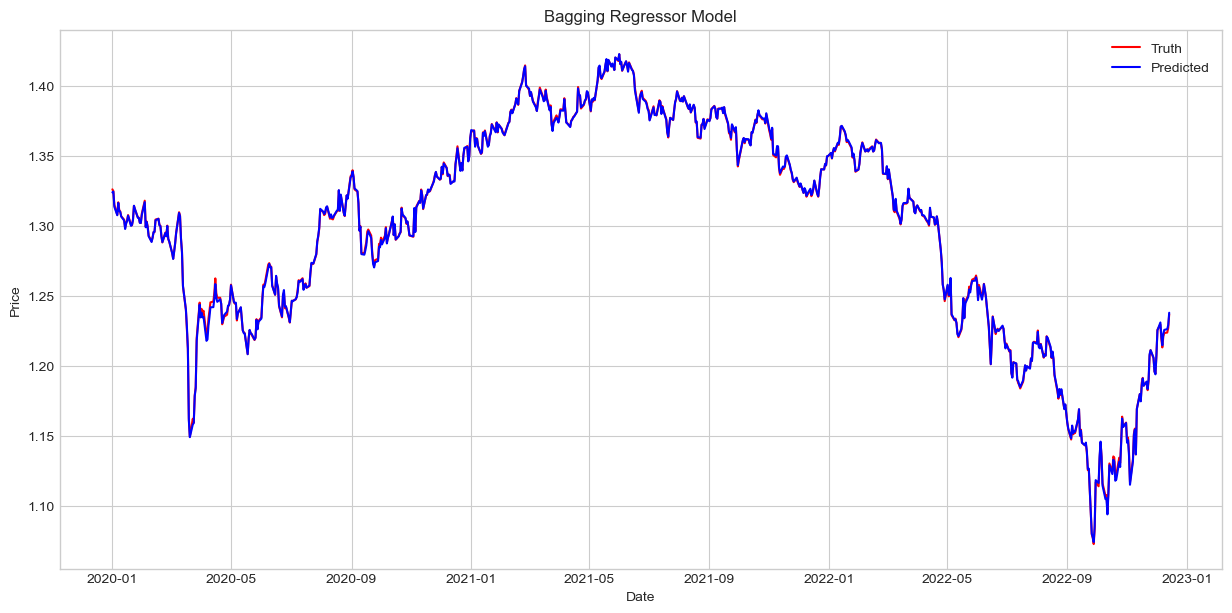

In [65]:
#Visualizing the predictions and truth values
pred = model.predict(X_scaled_test)
plt.figure(figsize=(15,7))
plt.plot(y_test, 'r', label='Truth')
plt.plot(y_test.index, pred, 'b', label='Predicted')
plt.title("Bagging Regressor Model")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

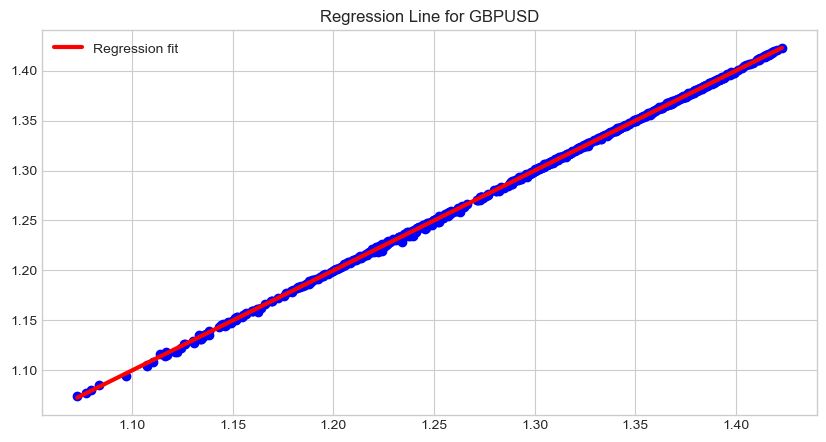

In [67]:
#plotting regression line
plt.style.use('seaborn-whitegrid')
plt.scatter(y_test, pred,color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=3, label='Regression fit')
fig = plt.gcf()
fig.set_size_inches(10,5)
plt.title("Regression Line for GBPUSD")
plt.legend()
plt.show()